# 6.6 Sourcing & Analyzing Time Series Data

# Index
## 1. Import Libraries and data
## 2. Subset data, data wrangling, and data cleaning
## 3. Time Series Analysis Decomposition
## 4. Test for Stationarity
## 5. Stationarizing Data

# 1. Import Libraries and Data

In [4]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using api imports the public access version of statsmodels, which is a library that handles statistical models
import os
import warnings # this library handles warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [5]:
# configure API key
quandl.ApiConfig.api_key = 'ZXPf_v7JP6v7uhtZX9ne'

In [6]:
# import data on Potential Gross Domestic Product
df = quandl.get('FRED/GDPPOT')

In [7]:
df.head()

,Value
Date,
1949-01-01,2102.982630
1949-04-01,2130.581305
1949-07-01,2159.340530
1949-10-01,2186.844859
1950-01-01,2216.058359


In [8]:
df.tail()

,Value
Date,
2030-10-01,23423.37
2031-01-01,23522.55
2031-04-01,23622.05
2031-07-01,23721.65
2031-10-01,23821.31


In [9]:
df.shape

(332, 1)

In [10]:
df.columns

Index(['Value'], dtype='object')

In [11]:
type(df)

pandas.core.frame.DataFrame

# 2. Subset, Wrangle, Clean Data

In [12]:
df2 = df.reset_index()

In [13]:
df2.head()

,Date,Value
0,1949-01-01,2102.982630
1,1949-04-01,2130.581305
2,1949-07-01,2159.340530
3,1949-10-01,2186.844859
4,1950-01-01,2216.058359


In [17]:
df_sub = df2.loc[(df2['Date'] >= '1990-01-01') & (df2['Date'] < '2020-12-31')]

In [18]:
df_sub.shape

(124, 2)

## Data has been subset between the dates 1990-01-01 and 2020-12-01 to help better analyze from more recent historical data and not possible future data as the data set went as far as the year 2030

In [19]:
# setting the Date column as the index
from datetime import datetime
df_sub['datetime'] = pd.to_datetime(df_sub['Date']) 
df_sub = df_sub.set_index('datetime')
df_sub.drop(['Date'], axis=1, inplace=True)
df_sub.head()

,Value
datetime,
1990-01-01,9344.347813
1990-04-01,9409.519331
1990-07-01,9473.370622
1990-10-01,9535.845016
1991-01-01,9597.373675


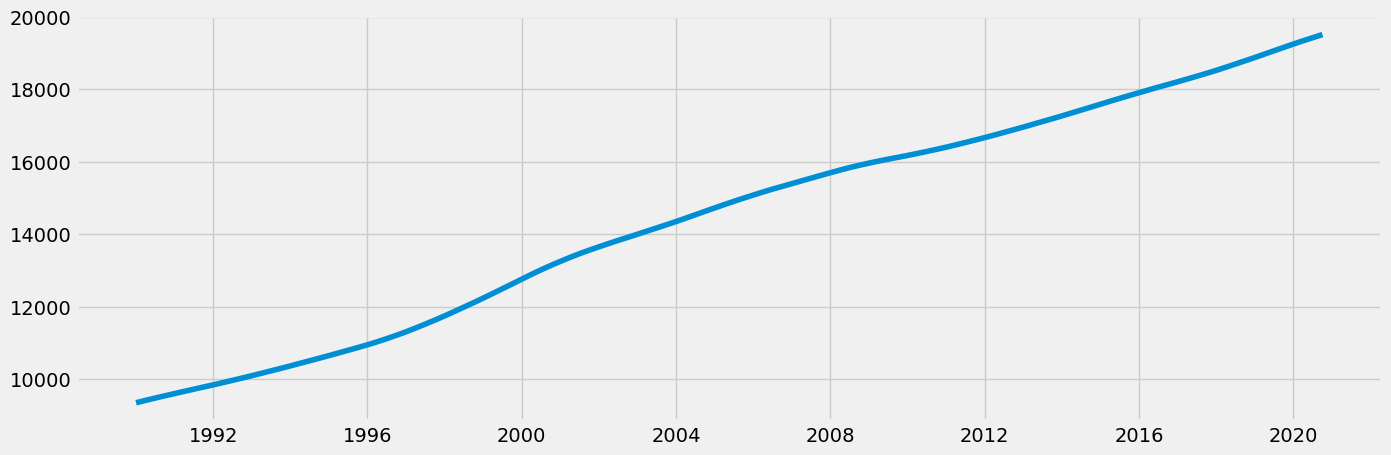

In [21]:
# creating a line chart to map the data points
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_sub)

In [22]:
#checking for missing values
df_sub.isnull().sum()

Value    0
dtype: int64

In [23]:
#checking for duplicate values
df_dups = df_sub.duplicated()
df_dups.sum()

0

### there are no missing values and no duplicate entries in the dataframe

# 3. Time Series Analysis: Decomposition

In [28]:
# Decomposing using an additive model
decomposition_add = sm.tsa.seasonal_decompose(df_sub, model='additive')

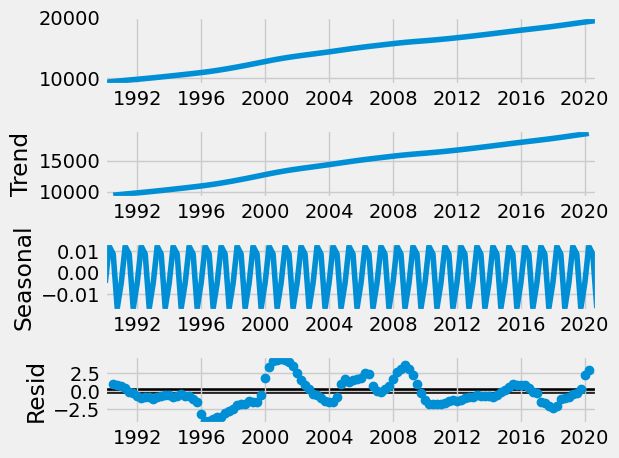

In [29]:
#Plot the points from the additive model
decomposition_add.plot()
plt.show()

In [30]:
# decomposition using a multiplicative model
decomposition_multi = sm.tsa.seasonal_decompose(df_sub, model='multiplicative')

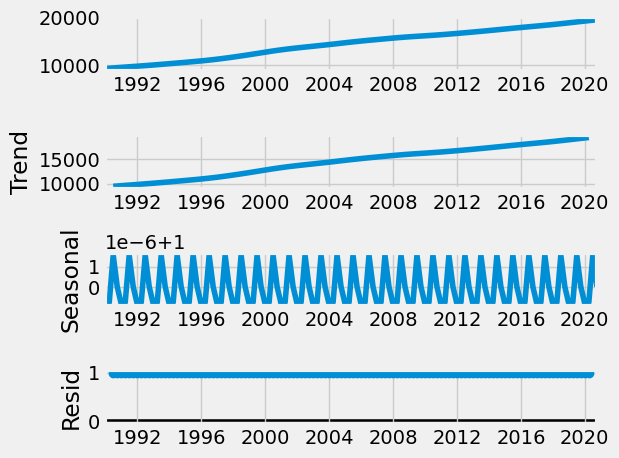

In [31]:
# plotting the points from the multiplicative model
decomposition_multi.plot()
plt.show()

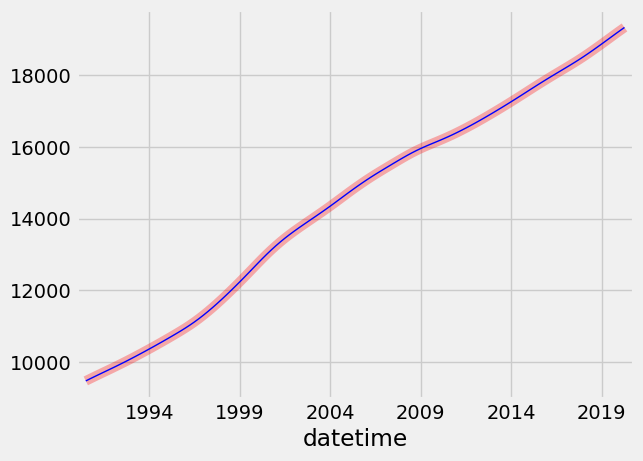

In [34]:
#analysing the trends from both models
decomposition_add.trend.plot(color='red', linewidth=7, alpha=0.3)
decomposition_multi.trend.plot(color='blue', linewidth=1)
plt.show()

## looking at the plot points for both the additive and multiplicative models the have the same trend patterns and seasonality. The residual component for additive has the points more spread out while for the multiplicative model the residual component is constant. This means that the multiplicative model will be better for this time series analysis.

# 4. Testing for Stationarity

In [36]:
# adfuller() will import from the model from statsmodels for the test. It will only return an array of numbers. This is why you need to define a function that prints the correct output from that array
from statsmodels.tsa.stattools import adfuller # importing the adfuller function
def dickey_fuller(timeseries): #define the function
    # Perform the dickey-fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key,value in test[4].items():
        result['Critical Value (%s)'%key] = value
    print(result)
    
# Apply the test using the function on the time series
dickey_fuller(df_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.379572
p-value                          0.913454
Number of Lags Used              2.000000
Number of Observations Used    121.000000
Critical Value (1%)             -3.485585
Critical Value (5%)             -2.885739
Critical Value (10%)            -2.579676
dtype: float64


### Test Statistic = -0.379572 which is larger than Critical value of -3.485585 so the null hypothesis can't be rejected
### significan level = 0.05 which is smaller than the p-value of 0.913454
### This means there is a unit root in the data and that the data is non-stationary

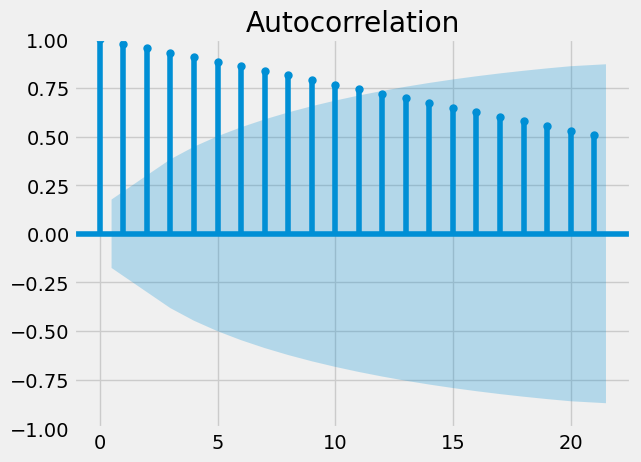

In [37]:
# checking the plot for autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # here, you import the autocorrelation and partial correlation plots
plot_acf(df_sub)
plt.show()

## the vertical lines respresent the lags in the series, the blue area represents the confidence level. From the graph above we see that over half of the lags go above the confidence level. This means that the lags are correlated with each other. This also means that the data is non-stationary which is also supported by the dickey_fuller test

# 5. Stationarizing the Data

In [38]:
df_diff = df_sub - df_sub.shift(1) # the df_sub.shift(1) function turns the observation to t-1, making the whole thing t - (t-1)

In [39]:
df_diff.dropna(inplace = True) # here, you remove the missing values that come about as a result of the differencing
# You need to remove these or you won't be able to run the dickey_fuller test

In [40]:
df_diff.head()

,Value
datetime,
1990-04-01,65.171518
1990-07-01,63.851291
1990-10-01,62.474394
1991-01-01,61.528659
1991-04-01,60.423709


In [41]:
df_diff.columns

Index(['Value'], dtype='object')

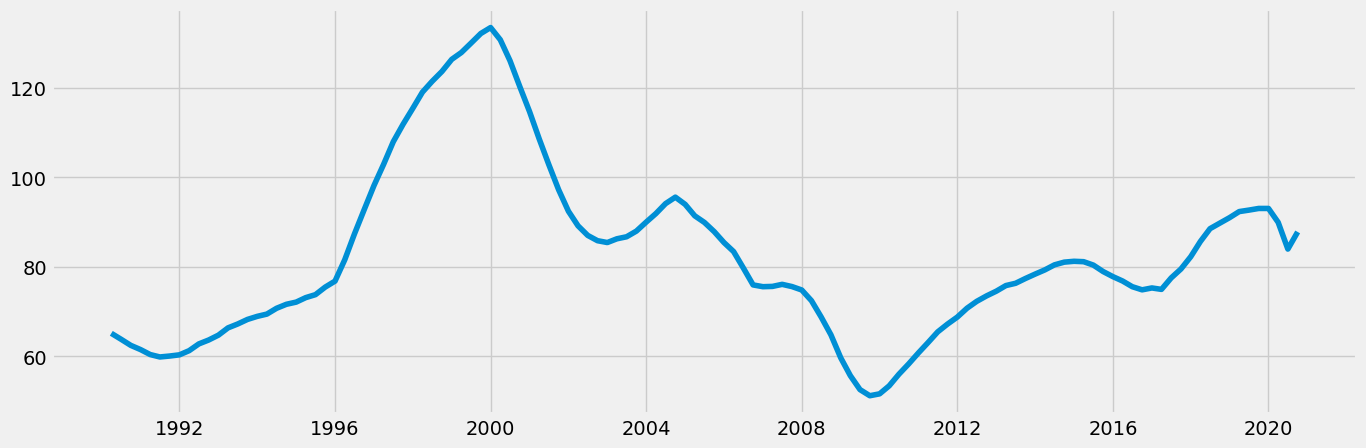

In [42]:
#checking what the differencing did to the time series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_diff)

In [43]:
dickey_fuller(df_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.838656
p-value                          0.052961
Number of Lags Used              1.000000
Number of Observations Used    121.000000
Critical Value (1%)             -3.485585
Critical Value (5%)             -2.885739
Critical Value (10%)            -2.579676
dtype: float64


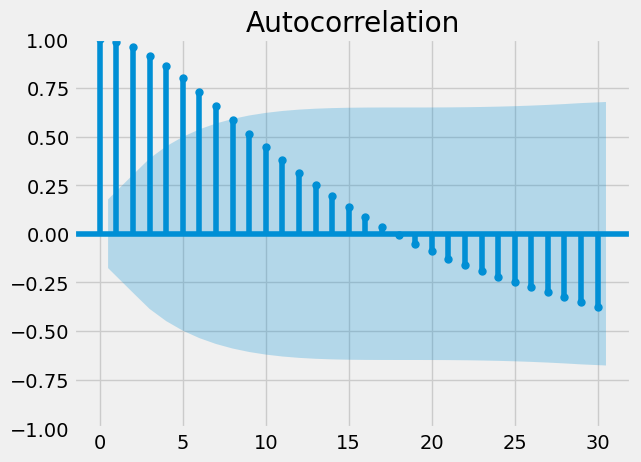

In [44]:
plot_acf(df_diff, lags=30)
plt.show()

## the autocorrelation has improved but the p value is still larger than the significant value of 0.05 which means the data isn't yet stationary

In [45]:
df_diff2 = df_diff - df_diff.shift(1)

In [46]:
df_diff2.dropna(inplace = True)

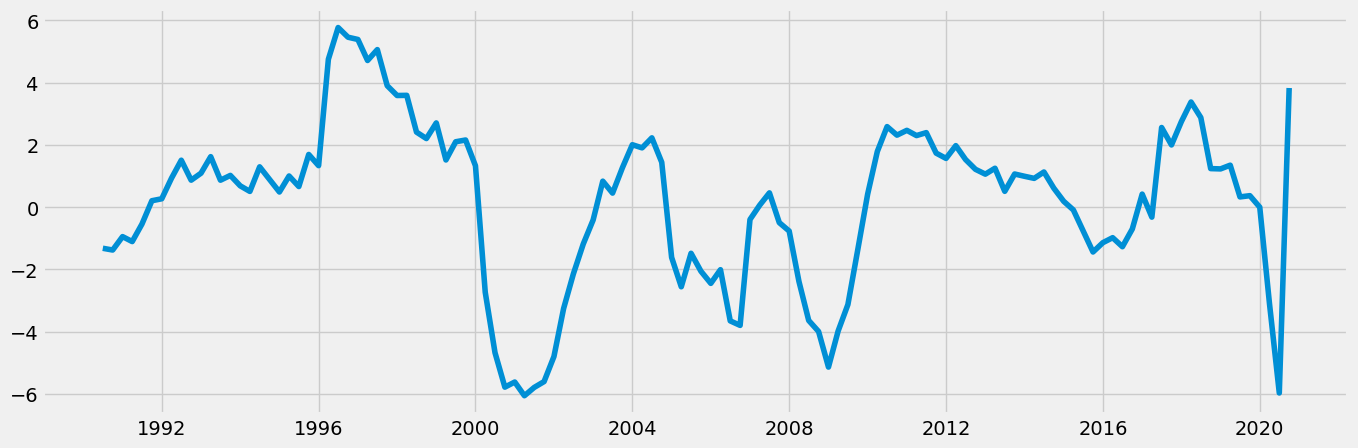

In [47]:
#checking what the differencing did to the time series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_diff2)

In [48]:
dickey_fuller(df_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.206093
p-value                          0.019635
Number of Lags Used              1.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64


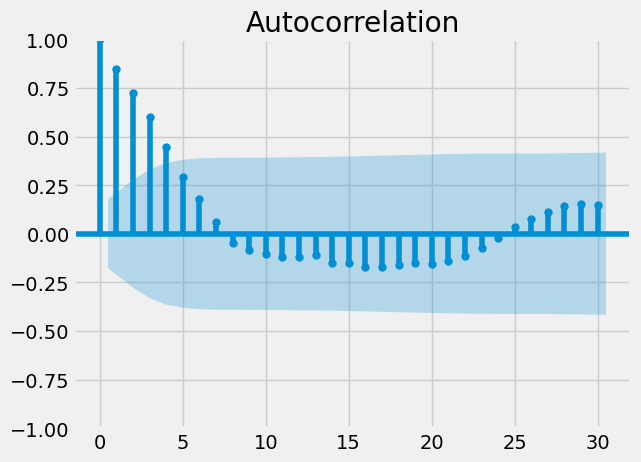

In [49]:
plot_acf(df_diff2, lags=30)
plt.show()

## There are still lags above the confidence with lags 1-5 but now the p-value is at 0.019635 from the dickey_fuller test is lower than the significant value of 0.05 which means the data is now stationary.